# Sign Language Model Detector

### Regarding the Project

##### DataSet
* Same Image Size
* Similar Background
* Intensity range
* Distributed Based on letter Presentation

##### Split Data
* Single Train/Val/Test 66%/17.5%/17.5%

##### Implement Optimizers
* Improve Runtime Due to CPU usage (Mac core)

##### Metrics
* Accuracy
* Confusion Matrix
* ROC Curve
* f1 Score

##### Set your callbacks and track the experiments
* Early stopping - patience
* Model check point
* Learning rate scheduler

##### Set the main hyperparameters
* batch size
* learning rate
* number of epochs

##### Train Model
* Adam as Optimizer
* Batch Size = 64
* Using TensorFlow

##### Implement Test
* Apply Predictions
* Extract relavent metrics
* Measure inference Time

#### Approach 1

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import image processing libraries
import cv2
import skimage
from skimage.transform import resize

# import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
import os
from tensorflow.keras.utils import to_categorical
from glob import glob
from random import sample
from random import random

2023-05-10 22:02:45.952452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
class_names = [
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "I",
    "J",
    "K",
    "L",
    "M",
    "N",
    "O",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
    "V",
    "W",
    "X",
    "Y",
    "Z",
    "del",
    "nothing",
    "space",
]

# Paths to the downloaded dataset
train_dir = "/Users/ferasdahrooge/Documents/WInter 2023/sign_language_detector/asl_dataset/asl-alphabet/asl_alphabet_train/asl_alphabet_train"

IMG_SIZE = (64, 64)
target_dims = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 64

# set the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode="categorical",
)

Found 87000 files belonging to 29 classes.


2023-05-10 22:02:58.056301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


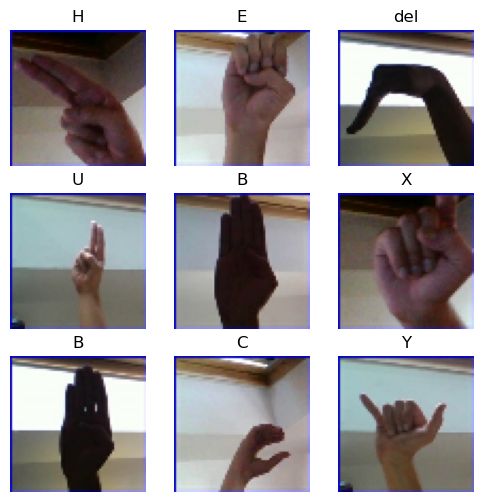

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(6, 6))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

### Split the Data 

In [35]:
training_batch = tf.data.experimental.cardinality(train_dataset)
number_of_batches = training_batch // 2
test_dataset = train_dataset.take(number_of_batches)
test_dataset = train_dataset.skip(number_of_batches)

print(
    "Number of training batches: %d"
    % tf.data.experimental.cardinality(train_dataset)
)
print(
    "Number of test batches: %d"
    % tf.data.experimental.cardinality(test_dataset)
)

Number of training batches: 1360
Number of test batches: 680


#### Split the testing dataset into validation dataset and testing dataset

In [36]:
number_of_batches_for_validation = number_of_batches // 2
validation_dataset = test_dataset.take(number_of_batches_for_validation)
test_dataset = test_dataset.skip(number_of_batches_for_validation)

print(
    "Number of validation batches: %d"
    % tf.data.experimental.cardinality(validation_dataset)
)
print(
    "Number of test batches: %d"
    % tf.data.experimental.cardinality(test_dataset)
)

Number of validation batches: 340
Number of test batches: 340


#### Apply AutoTune to Improve Training Runtime

In [37]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#### Define the Function to Preprocess the Data

In [40]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

#### Import Package for Model

In [41]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten
print("Packages imported...")

Packages imported...


#### Build CNN Model

In [42]:
model = Sequential()

model.add(Conv2D(32, (5, 5), input_shape=(64, 64, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(254, activation='relu'))
model.add(Dense(29, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        2432      
                                                                 
 activation (Activation)     (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                    

#### Apply Early Stopping

Early Stopping is done to make sure the model fitting stops at the most optimized accuracy point. After the early stopping point, the model might start overfitting. For testing purposes, this step can be skipped and complete training can be done.

In [44]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

#### Compile The Model 

This is used to configure the learning process by specifying the loss function, optimizer, and evaluation metrics that will be used during training

In [45]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Fit the Data into the Model

In [46]:
model.fit(train_dataset,
          epochs=20,
          batch_size=64,
          verbose=2,
          validation_data=(validation_dataset),
         callbacks=[early_stop])

Epoch 1/20
1360/1360 - 322s - loss: 1.1789 - accuracy: 0.6752 - val_loss: 0.2090 - val_accuracy: 0.9292 - 322s/epoch - 237ms/step
Epoch 2/20
1360/1360 - 331s - loss: 0.1735 - accuracy: 0.9416 - val_loss: 0.1100 - val_accuracy: 0.9658 - 331s/epoch - 243ms/step
Epoch 3/20
1360/1360 - 303s - loss: 0.1137 - accuracy: 0.9626 - val_loss: 0.0746 - val_accuracy: 0.9767 - 303s/epoch - 223ms/step
Epoch 4/20
1360/1360 - 276s - loss: 0.0901 - accuracy: 0.9723 - val_loss: 0.1246 - val_accuracy: 0.9638 - 276s/epoch - 203ms/step
Epoch 5/20
1360/1360 - 256s - loss: 0.0820 - accuracy: 0.9753 - val_loss: 0.0718 - val_accuracy: 0.9799 - 256s/epoch - 188ms/step
Epoch 6/20
1360/1360 - 1359s - loss: 0.0657 - accuracy: 0.9804 - val_loss: 0.1363 - val_accuracy: 0.9640 - 1359s/epoch - 999ms/step
Epoch 7/20
1360/1360 - 197s - loss: 0.0649 - accuracy: 0.9813 - val_loss: 0.0170 - val_accuracy: 0.9946 - 197s/epoch - 145ms/step
Epoch 8/20
1360/1360 - 367s - loss: 0.0635 - accuracy: 0.9830 - val_loss: 0.0532 - val_a

#### Model Evaluation

In [54]:
test_loss, test_accuracy  = model.evaluate(test_dataset,verbose=0)
# Print the test accuracy and loss
print("test loss: {:.2f}".format(test_loss))
print("test accuracy: {:.2f}".format(test_accuracy))

test loss: 0.02
test accuracy: 0.99


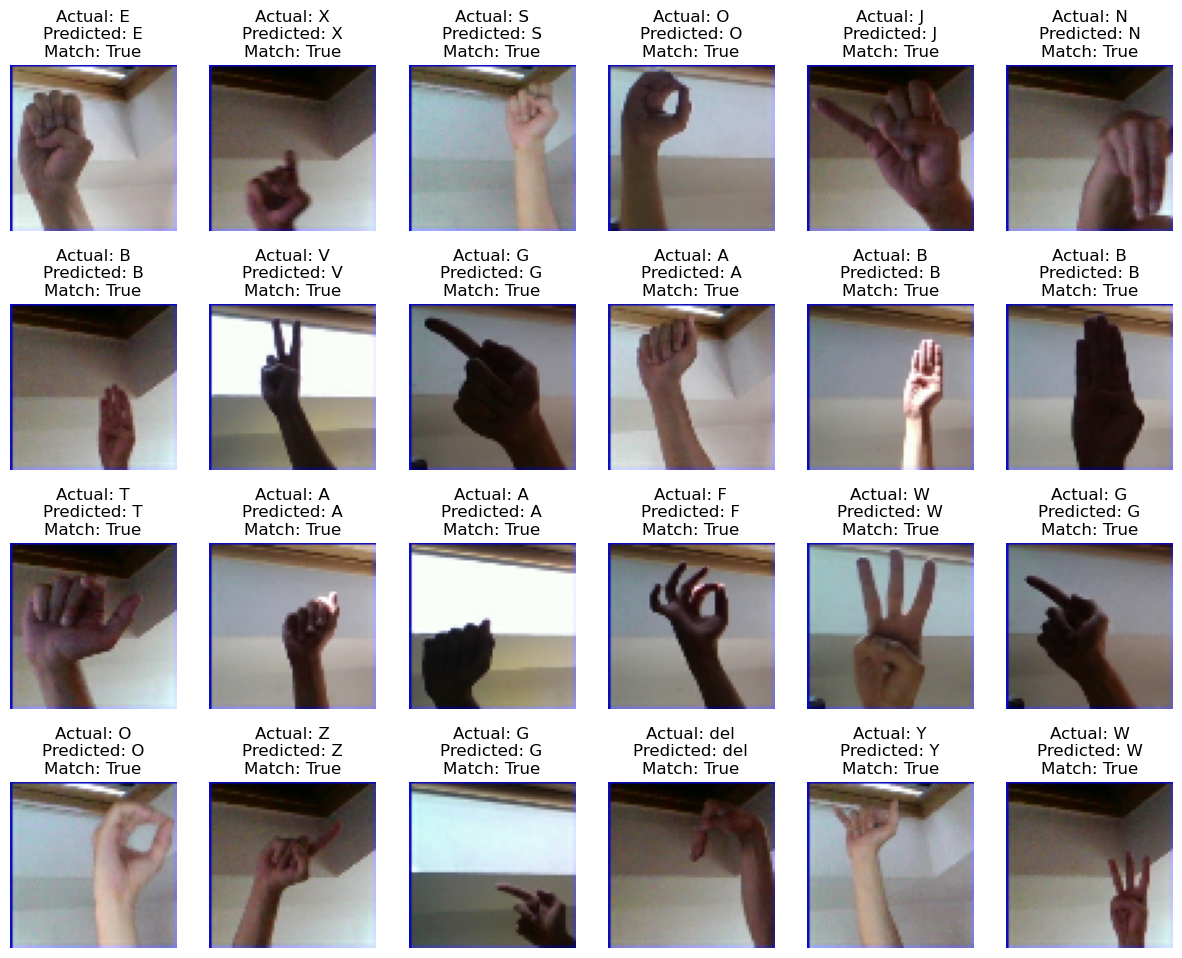

In [55]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# Make predictions
predictions = model.predict_on_batch(image_batch)

# Find the index of the highest prediction for each image
max_indices = np.argmax(predictions, axis=1)

# Get the class name for each predicted index
predicted_labels = [class_names[i] for i in max_indices]

# Convert the one-hot encoded labels to a single integer label
label_batch = np.argmax(label_batch, axis=1)

# Get the class name for each true index
actual_labels = [class_names[i] for i in label_batch]

# Plot the first 25 images and their predicted and true labels
plt.figure(figsize=(15, 15))
for i in range(24):
    ax = plt.subplot(5, 6, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"Actual: {actual_labels[i]}\nPredicted: {predicted_labels[i]}\nMatch: {actual_labels[i] == predicted_labels[i]}")
    plt.axis("off")

#### Base Model Predictions Based on every Image for Confusion Matrix Display

In [56]:
# Initialize empty lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Loop over the test dataset
for images, labels in test_dataset:

    # Make predictions using the trained model
    predictions = model.predict(images)

    # Store the predicted labels
    predicted_labels.extend(predictions)
    
    # Store the true labels
    true_labels.extend(labels)

# Convert the lists to NumPy arrays and find the index of the highest prediction for each image
predicted_labels = np.argmax(predicted_labels, axis=1)
true_labels = np.argmax(true_labels, axis=1)

1/1 [==============================] - 0s 80ms/step


#### Display Confusion Matrix

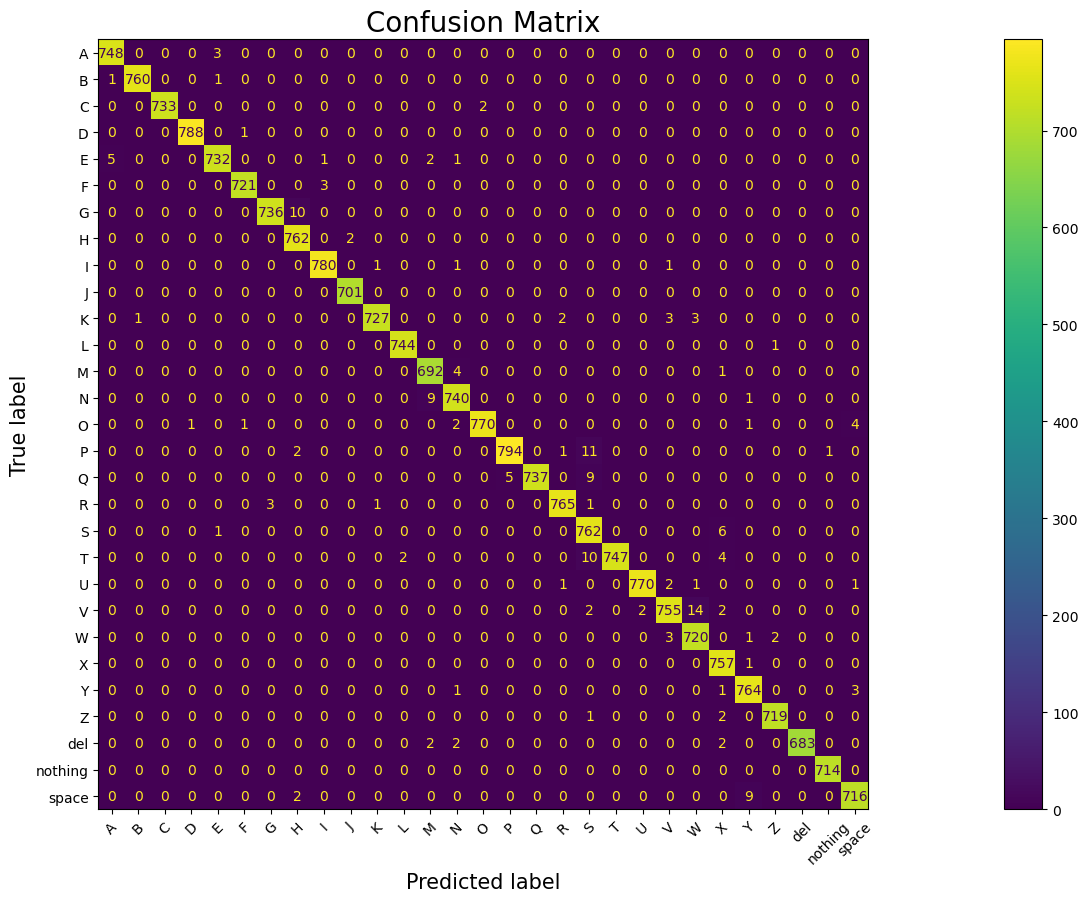

Accuracy: 0.9915745856353592


In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Create figure and axes
fig, ax = plt.subplots(figsize=(35, 10))
disp.plot(ax=ax)

# Set axis labels and title
ax.set_xlabel('Predicted label', fontsize=15)
ax.set_ylabel('True label', fontsize=15)
ax.set_title('Confusion Matrix', fontsize=20)

# Slant the horizontal labels
plt.xticks(rotation=45)

# Show the plot
plt.show()

# Calculate accuracy
accuracy = np.sum(np.diagonal(cm)) / np.sum(cm)
print("Accuracy:", accuracy)

#### Get F1 Score Based on the Labelling

In [59]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(true_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       751
           1       1.00      1.00      1.00       762
           2       1.00      1.00      1.00       735
           3       1.00      1.00      1.00       789
           4       0.99      0.99      0.99       741
           5       1.00      1.00      1.00       724
           6       1.00      0.99      0.99       746
           7       0.98      1.00      0.99       764
           8       0.99      1.00      1.00       783
           9       1.00      1.00      1.00       701
          10       1.00      0.99      0.99       736
          11       1.00      1.00      1.00       745
          12       0.98      0.99      0.99       697
          13       0.99      0.99      0.99       750
          14       1.00      0.99      0.99       779
          15       0.99      0.98      0.99       809
          16       1.00      0.98      0.99       751
          17       0.99    

In [60]:
model.save("asl-model.h5")